In [45]:
# FMA/Audio Processing utilities
import tools.fma_utils as fma_utils 
import tools.audio_utils as audio_utils

# Dataset utilities
import tools.data_tools as data_utils

from pydub import AudioSegment
import numpy as np

# general
import dotenv
import matplotlib.pyplot as plt
import IPython.display as ipd
import os
import pickle

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Get mp3 paths
Get paths to some mp3s. 

### (FMA) Get FMA paths
If you have your own audio paths skip this.

In [46]:
# Size of FMA subset
num_files = 10 #for fma_small, needs to be <1000
# Top 'Genre' Subset
top_genre = 'Electronic'

# I use dotenv you can just specify manually
dotenv.load_dotenv(dotenv.find_dotenv())
AUDIO_DIR = os.environ.get('AUDIO_DIR') #path to unziped fma_small
METADATA_DIR = os.environ.get('METADATA_DIR') #path to unzipped fma_metadata
print("Audio Dir: {}\nMetadata Dir: {}".format(AUDIO_DIR,METADATA_DIR))

# Load all tracks (might take a few seconds)
tracks = fma_utils.load(os.path.join(METADATA_DIR, 'tracks.csv'))

# Get 'small' subset
small = tracks['set', 'subset'] <= 'small'
tracks_small = tracks[small] # dataframe with only 'small' subset tracks

# genre subst
genre_mask = tracks_small['track', 'genre_top'] == top_genre
genre_tracks = tracks_small[genre_mask]

# get index values
genre_index = genre_tracks.index.values
genre_index = genre_index[:num_files]

# generate file lists
audio_paths = data_utils.fma_paths_from_indices(genre_index, AUDIO_DIR)

# Show a few paths
print("Audio Paths: ")
ipd.display(audio_paths[:5])

Audio Dir: /home/actlab/mark/fma-stft/data/fma_small
Metadata Dir: /home/actlab/mark/fma-stft/data/fma_metadata


/home/actlab/mark/fma-stft/tools/fma_utils.py:215: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  'category', categories=SUBSETS, ordered=True)


Audio Paths: 


['/home/actlab/mark/fma-stft/data/fma_small/001/001482.mp3',
 '/home/actlab/mark/fma-stft/data/fma_small/003/003573.mp3',
 '/home/actlab/mark/fma-stft/data/fma_small/004/004519.mp3',
 '/home/actlab/mark/fma-stft/data/fma_small/004/004520.mp3',
 '/home/actlab/mark/fma-stft/data/fma_small/004/004521.mp3']

### Define your own audio paths
Skip if using fma paths from above.
define "audio_paths" as a list of paths

In [47]:
# glob might be useful for this from glob import glob; glob("thedir/*.mp3")
# audio_paths = {}

# Dataset Parameters

In [48]:
# dataset size parameters
num_files = len(audio_paths)
num_specs = 6 #number of spectrograms to create for each file
spec_len = 10 #length of spectrogram in seconds
total_specs = num_files * num_specs
# (if num_specs*spec_len > audio length, spectrograms will be generated with overlapping windows)

# fft / stft parameters
useLog = True #use log scale when generating spectrograms
sample_rate = 44100 # sample rate of audio in hz to use
fft_size = 2048  # window size for the FFT
step_size = fft_size // 16  # distance to slide along the window (in time)
spec_thresh = 10  # threshold for spectrograms (lower filters out more noise)

# mel parameters
n_mel_freq_components = 128  # number of mel frequency channels
shorten_factor = 4  # how much should we compress the x-axis (time)
start_freq = 2  # Hz # What frequency to start sampling our melS from
end_freq = 22000  # Hz # What frequency to stop sampling our melS from

### Optional: Test dataset fft/filter parameters
This creates a spectrogram & mel-compressed spectrogram and inverts them back into audio using above parameters. You might want to mess with the parameters to make better sounding inversions

Original Spectrogram Shape: (1024, 3440)
Mel-Compressed Spectrogram: (128, 858)
Regular Spectrogram: 


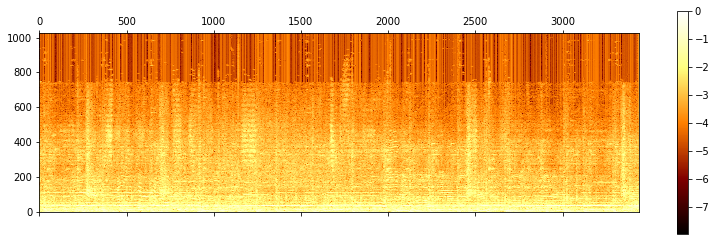

Mel Spectrogram: 


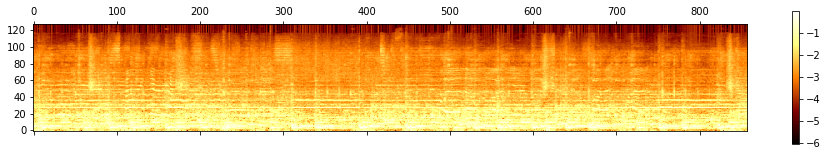

Reconstructed Mel Spectrogram: 


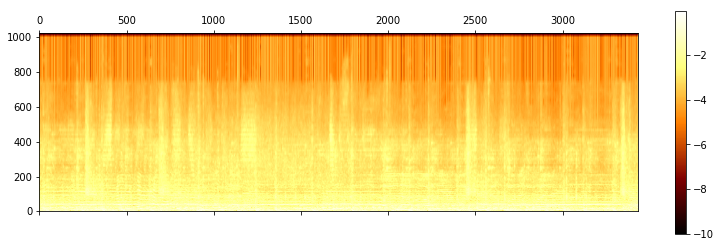

Original


Reconstructed


Mel-Reconstructed


In [49]:
# Load song and get mono-channel wave
audio_seg, audio_wave = data_utils.mono_wave_from_mp3(audio_paths[2],
                                                      sample_rate=sample_rate,
                                                      t_start=0,
                                                      t_stop=spec_len)

######################## Spectrogram ########################

#regular
spec = audio_utils.pretty_spectrogram(audio_wave.astype('float64'), fft_size=fft_size,
                                           step_size=step_size, log=useLog, thresh=spec_thresh).astype('float32')


######################## Mel-Spectrogram ########################

# create_mel_filter gives both the foward and inverse mel filters
mel_filter, mel_inversion_filter = audio_utils.create_mel_filter(fft_size=fft_size,
                                                                 n_freq_components=n_mel_freq_components,
                                                                 start_freq=start_freq,
                                                                 end_freq=end_freq,
                                                                 samplerate=sample_rate)

# mel spectrograms
mel_spec = audio_utils.make_mel(spec, mel_filter, shorten_factor=shorten_factor)

# Inverted spectrograms
mel_recon_spec = audio_utils.mel_to_spectrogram(mel_spec, mel_inversion_filter,
                                                     spec_thresh=spec_thresh,
                                                     shorten_factor=shorten_factor)

######################## Data Dimensions ########################

print("Original Spectrogram Shape: {}".format((spec.shape[1],spec.shape[0])))

print("Mel-Compressed Spectrogram: {}".format(mel_spec.shape))

######################## Display Spectrograms ########################

plt.rcParams['figure.figsize'] = (18, 4)
print("Regular Spectrogram: ")
cax1 = plt.matshow(spec.transpose(), interpolation='nearest', cmap=plt.cm.afmhot, origin='lower')
plt.colorbar(cax1)
plt.show()
print("Mel Spectrogram: ")
cax2 = plt.matshow(mel_spec, interpolation='nearest', cmap=plt.cm.afmhot, origin='lower')
plt.colorbar(cax2)
plt.show()
print("Reconstructed Mel Spectrogram: ")
cax3 = plt.matshow(mel_recon_spec, interpolation='nearest', cmap=plt.cm.afmhot, origin='lower')
plt.colorbar(cax3)
plt.show()

######################## Listen To Audio ########################
# This takes a few seconds
recon_wave = audio_utils.invert_pretty_spectrogram(spec.astype(np.float32), fft_size = fft_size,
                                    step_size = step_size, log = useLog, n_iter = 16)
mel_recon_wave = audio_utils.invert_pretty_spectrogram(np.transpose(mel_recon_spec), fft_size = fft_size,
                                            step_size = step_size, log = useLog, n_iter = 16)
                                            
# Play back recovered audio
print("Original")
ipd.display(ipd.Audio(audio_wave, rate=sample_rate))
print("Reconstructed")
ipd.display(ipd.Audio(recon_wave, rate=sample_rate))
print("Mel-Reconstructed")
ipd.display(ipd.Audio(mel_recon_wave, rate=sample_rate))

# Build a Regular Spectrogram Dataset

In [50]:
# build the dataset
ds = data_utils.spectrogram_dataset(audio_paths,
                        nspecs_file=num_specs,
                        spec_len = spec_len,
                        sample_rate = sample_rate,
                        fft_size = fft_size,
                        step_size = step_size,
                        log_scale=useLog,
                        spec_threshold = spec_thresh,
                        quiet = False)


Processing 1/10: /home/actlab/mark/fma-stft/data/fma_small/001/001482.mp3
Processing 2/10: /home/actlab/mark/fma-stft/data/fma_small/003/003573.mp3
Processing 3/10: /home/actlab/mark/fma-stft/data/fma_small/004/004519.mp3
Processing 4/10: /home/actlab/mark/fma-stft/data/fma_small/004/004520.mp3
Processing 5/10: /home/actlab/mark/fma-stft/data/fma_small/004/004521.mp3
Processing 6/10: /home/actlab/mark/fma-stft/data/fma_small/004/004522.mp3
Processing 7/10: /home/actlab/mark/fma-stft/data/fma_small/007/007011.mp3
Processing 8/10: /home/actlab/mark/fma-stft/data/fma_small/011/011206.mp3
Processing 9/10: /home/actlab/mark/fma-stft/data/fma_small/011/011262.mp3
Processing 10/10: /home/actlab/mark/fma-stft/data/fma_small/011/011942.mp3


In [51]:
# Dataset is a dictionary
print("Spectrogram Dataset dictionary: ")
print("  ds['data'] entries: {}".format(len(ds['data']))) #should be num_specs*len(audio_paths)
print("  ds['data'] shape: {}".format(ds['data'][0].shape))
print("  ds['mp3_paths'] entries: {}".format(len(ds['mp3_paths']))) #should be num_specs*len(audio_paths)
print("  ds['sample_rate']: {}".format(ds['sample_rate']))
print("  ds['log_scale']: {}".format(ds['log_scale']))
print("  ds['spec_len']: {}".format(ds['spec_len']))
print("  ds['spec_per_file']: {}".format(ds['spec_per_file']))
print("  ds['spec_threshold']: {}".format(ds['spec_threshold']))
print("  ds['fft_size']: {}".format(ds['fft_size']))
print("  ds['step_size']: {}".format(ds['step_size']))

Spectrogram Dataset dictionary: 
  ds['data'] entries: 60
  ds['data'] shape: (1024, 3440)
  ds['mp3_paths'] entries: 60
  ds['sample_rate']: 44100
  ds['log_scale']: True
  ds['spec_len']: 10
  ds['spec_per_file']: 6
  ds['spec_threshold']: 10
  ds['fft_size']: 2048
  ds['step_size']: 128


# Build a Mel-Spectrogram Dataset
Do this by converting regular dataset (since mel-spectrograms require regular spectrogram data anyway)

In [52]:
#convert dataset to mel dataset
mel_ds = data_utils.melspec_dataset(ds,
                                    freq_components=n_mel_freq_components,
                                    shorten=shorten_factor,
                                    low_freq=start_freq,
                                    high_freq=end_freq,
                                    quiet=False)

Processing 1/10: /home/actlab/mark/fma-stft/data/fma_small/001/001482.mp3
Processing 2/10: /home/actlab/mark/fma-stft/data/fma_small/003/003573.mp3
Processing 3/10: /home/actlab/mark/fma-stft/data/fma_small/004/004519.mp3
Processing 4/10: /home/actlab/mark/fma-stft/data/fma_small/004/004520.mp3
Processing 5/10: /home/actlab/mark/fma-stft/data/fma_small/004/004521.mp3
Processing 6/10: /home/actlab/mark/fma-stft/data/fma_small/004/004522.mp3
Processing 7/10: /home/actlab/mark/fma-stft/data/fma_small/007/007011.mp3
Processing 8/10: /home/actlab/mark/fma-stft/data/fma_small/011/011206.mp3
Processing 9/10: /home/actlab/mark/fma-stft/data/fma_small/011/011262.mp3
Processing 10/10: /home/actlab/mark/fma-stft/data/fma_small/011/011942.mp3


In [53]:
#Dataset form is similar to original, just with more entries
print("Mel-Spectrogram Dataset dictionary: ")
print("  mel_ds['data'] entries: {}".format(len(mel_ds['data'])))  # should be num_specs*len(audio_paths)
print("  mel_ds['data'] shape: {}".format(mel_ds['data'][0].shape))
print("  mel_ds['mp3_paths'] entries: {}".format(len(mel_ds['mp3_paths'])))  # should be num_specs*len(audio_paths)
print("  mel_ds['sample_rate']: {}".format(mel_ds['sample_rate']))
print("  mel_ds['log_scale']: {}".format(mel_ds['log_scale']))
print("  mel_ds['spec_len']: {}".format(mel_ds['spec_len']))
print("  mel_ds['spec_per_file']: {}".format(mel_ds['spec_per_file']))
print("  mel_ds['spec_threshold']: {}".format(mel_ds['spec_threshold']))
print("  mel_ds['fft_size']: {}".format(mel_ds['fft_size']))
print("  mel_ds['step_size']: {}".format(mel_ds['step_size']))
print("  mel_ds['freq_components']: {}".format(mel_ds['freq_components']))
print("  mel_ds['shorten_factor']: {}".format(mel_ds['shorten_factor']))
print("  mel_ds['low_freq']: {}".format(mel_ds['low_freq']))
print("  mel_ds['high_freq']: {}".format(mel_ds['high_freq']))
print("  mel_ds['mel_filter'] shape: {}".format(mel_ds['mel_filter'].shape))
print("  mel_ds['inv_mel_filter'] shape: {}".format(mel_ds['inv_mel_filter'].shape))

Mel-Spectrogram Dataset dictionary: 
  mel_ds['data'] entries: 60
  mel_ds['data'] shape: (128, 858)
  mel_ds['mp3_paths'] entries: 60
  mel_ds['sample_rate']: 44100
  mel_ds['log_scale']: True
  mel_ds['spec_len']: 10
  mel_ds['spec_per_file']: 6
  mel_ds['spec_threshold']: 10
  mel_ds['fft_size']: 2048
  mel_ds['step_size']: 128
  mel_ds['freq_components']: 128
  mel_ds['shorten_factor']: 4
  mel_ds['low_freq']: 2
  mel_ds['high_freq']: 22000
  mel_ds['mel_filter'] shape: (1024, 128)
  mel_ds['inv_mel_filter'] shape: (128, 1024)


# (Optional) Make some pickles!
Just saving dataset for use later

In [54]:
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb+') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open('name' + '.pkl', 'rb') as f:
        return pickle.load(f)

In [55]:
save_obj(ds,'spec_ds')
save_obj(mel_ds,'mel_ds')